## 1. Define a function that calculates our special dispersion function

In [1]:
def dispersion_funcion(z):
    import numpy as np
   # from plasmapy.dispersion import plasma_dispersion_func
    from scipy import special
    
   # Zeta_00 = np.sqrt(np.pi)*plasma_dispersion_func(z)
    Zeta_00 = 1j*np.pi*special.wofz(z)
    Zeta_10 = z*Zeta_00 + special.gamma(1/2)
        
    return 1/(np.sqrt(np.pi))*Zeta_10
    

## 2. Define a function that calculates the expression for the dispersion relation

In [12]:
# define a function for the dispersion relation
def full_dispersion_relation(x, k_z_lambda):
    import numpy as np
   
    # x = omega/Omega_i (normalised complex frequency)
    
    # set the parameters
    k_y_lambda = 0.1 # k_y * lambda_i
    L_n_lambda = 10**5 # L_n/lambda_i
    L_T_lambda = 10 # L_T/lambda_i
    temp_ratio = 10 # T_e/T_i
    mass_ratio = 1836 # m_i/m_e (protons)
    lambda_d = 10**2 # lambda_i/lambda_D
        
    # normalised omega^T_i
    omega_ti = k_y_lambda*L_T_lambda**(-1)
    # normalised omega^T_e
    omega_te = - k_y_lambda*L_T_lambda**(-1)*temp_ratio
    
    # normalised omega^n_i
    omega_ni = k_y_lambda*L_n_lambda**(-1)
    # normalised omega^n_e
    omega_ne = - k_y_lambda*L_n_lambda**(-1)*temp_ratio
    
    z_i = x/k_z_lambda
    z_e = x/(k_z_lambda*temp_ratio**(1/2)*mass_ratio**(1/2))
    
    xi_i = k_y_lambda**2
    xi_e = (k_y_lambda*mass_ratio**(-1/2)*temp_ratio**(1/2))**2
        
    bes_i0 = special.ive(0, xi_i) # order 0 bessel function for ions
    bes_i1 = special.ive(1, xi_i) # order 1 bessel function for ions
    # order 0 bessel function for electrons
    bes_e0 = special.ive(0, xi_e)
    # order 1 bessel function for electrons
    bes_e1 = special.ive(1, xi_e)

    Wi = dispersion_funcion(z_i)
    We = dispersion_funcion(z_e/np.sqrt(2.0))
    
    # return the expression for the dispersion relation
    return x*temp_ratio*(k_z_lambda**2 *lambda_d**(-2) + k_y_lambda**2 *lambda_d**(-2)) + x*(1 + We*bes_e0 - bes_e0) + (-omega_ne + omega_te/2)*(We-1)*bes_e0 - omega_te*(z_e**2 *We*bes_e0/2 + (We-1)*xi_e*(bes_e1-bes_e0)) + temp_ratio*(x*(1+Wi*bes_i0-bes_i0) + (-omega_ni + omega_ti/2)*(Wi-1)*bes_i0 - omega_ti*(z_i**2 *Wi*bes_i0 + (Wi-1)*xi_i*(bes_i1-bes_i0)))

## 3. Solve the dispersion relation numerically

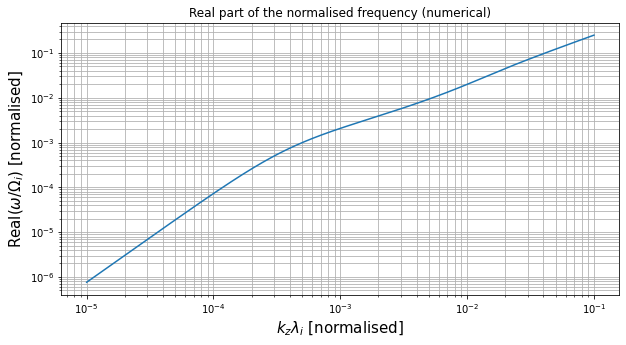

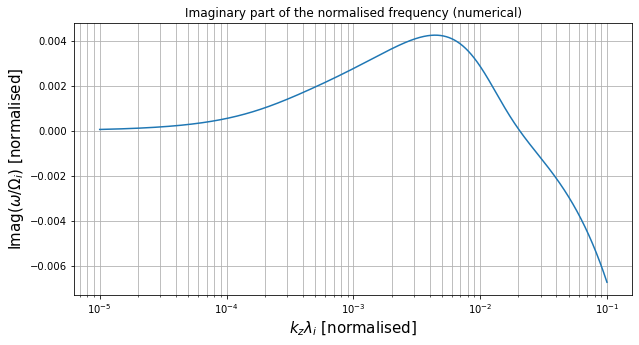

In [13]:
# calculate the full numerical solution
import numpy as np
import matplotlib.pyplot as plt
from scipy import special, optimize

# define values for k_z * lambda_i
k_z_lambda = np.logspace(-5, -1, 10000)
# turn it to python list for the indexing in the loop
# it's easier compared to the numpy array
k_z_lambda_list = k_z_lambda.tolist() 

full_omega_numerical = [] # list to keep the root

# first loop for the first results
for i in k_z_lambda_list[:100]:
    # find the root
    solution = optimize.root_scalar(full_dispersion_relation, x0 = 0.00001 + 0j, 
                                     x1 = 0.00003 + 0.0001j, args=i, method='secant')
    # save the root
    full_omega_numerical.append(solution.root)
    
    #print(k_z_lambda_list.index(i))

# big loop that uses as guesses the previous roots
for i in k_z_lambda_list[100:]:
    
    # add some noise to the roots for the guesses
    guess_0 = full_omega_numerical[k_z_lambda_list.index(i)-1] + full_omega_numerical[k_z_lambda_list.index(i)-1]/10
    
    guess_1 = full_omega_numerical[k_z_lambda_list.index(i)-1] - full_omega_numerical[k_z_lambda_list.index(i)-1]/10
    
    # calculate root
    solution = optimize.root_scalar(full_dispersion_relation, x0 = guess_0, 
                                    x1 = guess_1, args=i, method='secant')
    # save root
    full_omega_numerical.append(solution.root)
    
## plot full numerical solution

# turn it into a numpy array again
# plot second numerical solution

# turn it into a numpy array again
full_omega_numerical = np.asarray(full_omega_numerical)

# plot frequency
plt.subplots(figsize=(10,5))

# plot real part for both roots
plt.plot(k_z_lambda_list, full_omega_numerical.real)

# fix the plot label's etc
plt.xlabel('$k_z \lambda_i$ [normalised]', fontsize=15.0)
plt.title('Real part of the normalised frequency (numerical)')
plt.ylabel('Real($\omega / \Omega_i$) [normalised]', fontsize=15.0)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="-")

plt.show()

# plot imaginary part for both roots
plt.subplots(figsize=(10,5))

plt.plot(k_z_lambda_list, full_omega_numerical.imag)

plt.xlabel('$k_z \lambda_i$ [normalised]', fontsize=15.0)
plt.title('Imaginary part of the normalised frequency (numerical)')
plt.ylabel('Imag($\omega / \Omega_i$) [normalised]', fontsize=15.0)
plt.xscale('log')
plt.grid(True, which="both", ls="-")
#plt.ylim(-0.005, 0.005)
plt.show()

## 4. Compare against the reference figure

In [11]:
from numpy import loadtxt
# load data for the reference figure
analytical_data_imaginary = loadtxt('D:/MSc/OneDrive - University of York/MSc/project/Reference_Analytical_imaginary.csv', delimiter=',')
numerical_data_imaginary = loadtxt('D:/MSc/OneDrive - University of York/MSc/project/Reference_Numerical_imaginary.csv', delimiter=',')

analytical_data_real = loadtxt('D:/MSc/OneDrive - University of York/MSc/project/Reference_Analytical_real.csv', delimiter=',')
numerical_data_real = loadtxt('D:/MSc/OneDrive - University of York/MSc/project/Reference_Numerical_real.csv', delimiter=',')

In [12]:
# set lists for the data of the reference figure

# real part analytical
k_z_lambda_analytical_real = []
frequency_analytical_real = []

# real part numerical
k_z_lambda_numerical_real = []
frequency_numerical_real = []

# imaginary part analytical
k_z_lambda_analytical_imaginary = []
growth_rate_analytical = []

# imaginary part numerical
k_z_lambda_numerical_imaginary = []
growth_rate_numerical = []

# store the analytical real part
for i in range(len(analytical_data_real)):
    
    k_z_lambda_analytical_real.append(analytical_data_real[i][0])
    frequency_analytical_real.append(analytical_data_real[i][1])
    
# store the numerical real part 
for i in range(len(numerical_data_real)):
    
    k_z_lambda_numerical_real.append(numerical_data_real[i][0])
    frequency_numerical_real.append(numerical_data_real[i][1])

# store the analytical imaginary part 
for i in range(len(analytical_data_imaginary)): 
    
    k_z_lambda_analytical_imaginary.append(analytical_data_imaginary[i][0])
    growth_rate_analytical.append(analytical_data_imaginary[i][1])
    
# store the numerical imaginary part 
for i in range(len(numerical_data_imaginary)): 
    
    k_z_lambda_numerical_imaginary.append(numerical_data_imaginary[i][0])
    growth_rate_numerical.append(numerical_data_imaginary[i][1])

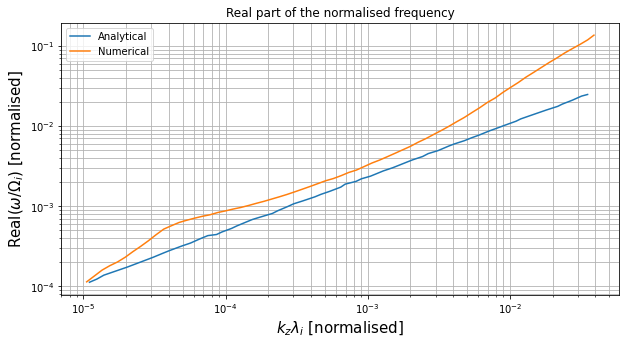

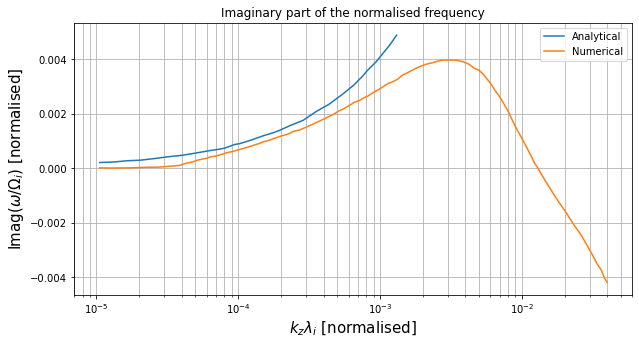

In [13]:
# plot the real part of the reference figure
plt.subplots(figsize=(10,5))

plt.plot(k_z_lambda_analytical_real, frequency_analytical_real, label='Analytical')
plt.plot(k_z_lambda_numerical_real, frequency_numerical_real, label='Numerical')
plt.xlabel('$k_z \lambda_i$ [normalised]', fontsize=15.0)
plt.title('Real part of the normalised frequency')
plt.ylabel('Real($\omega / \Omega_i$) [normalised]', fontsize=15.0)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="-")
plt.legend()
plt.show()

# plot the imaginary part (growth-rate) of the reference figure
plt.subplots(figsize=(10,5))

plt.plot(k_z_lambda_analytical_imaginary, growth_rate_analytical, label='Analytical')
plt.plot(k_z_lambda_numerical_imaginary, growth_rate_numerical, label='Numerical')
plt.xlabel('$k_z \lambda_i$ [normalised]', fontsize=15.0)
plt.title('Imaginary part of the normalised frequency')
plt.ylabel('Imag($\omega / \Omega_i$) [normalised]', fontsize=15.0)
plt.xscale('log')
plt.grid(True, which="both", ls="-")
plt.legend()
plt.show()

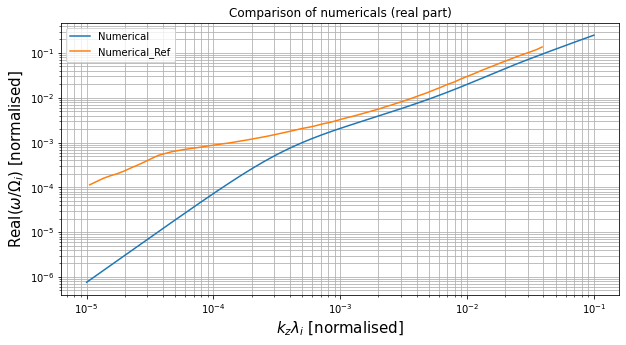

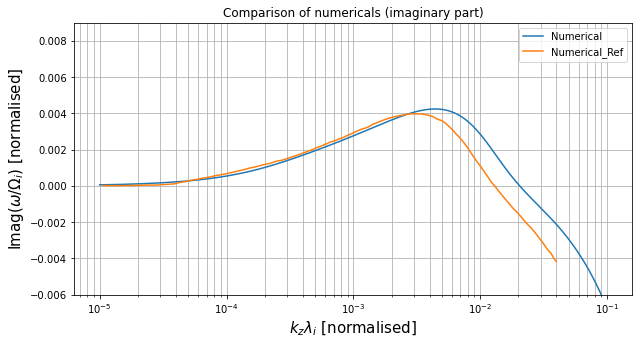

In [14]:
# real part
plt.subplots(figsize=(10,5))
# plot the full numerical solution
plt.plot(k_z_lambda, full_omega_numerical.real, label='Numerical')
# reference numerical solution
plt.plot(k_z_lambda_numerical_real, frequency_numerical_real, label='Numerical_Ref')

# set the plot axis etc.
plt.xlabel('$k_z \lambda_i$ [normalised]', fontsize=15.0)
plt.title('Comparison of numericals (real part)')
plt.ylabel('Real($\omega / \Omega_i$) [normalised]', fontsize=15.0)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="-")
plt.legend()
plt.show()

# imaginary part
plt.subplots(figsize=(10,5))

# plot the full numerical solution
plt.plot(k_z_lambda_list, full_omega_numerical.imag, label='Numerical')
# reference numerical solution
plt.plot(k_z_lambda_numerical_imaginary, growth_rate_numerical, label='Numerical_Ref')

# set the plot axis etc.
plt.xlabel('$k_z \lambda_i$ [normalised]', fontsize=15.0)
plt.title('Comparison of numericals (imaginary part)')
plt.ylabel('Imag($\omega / \Omega_i$) [normalised]', fontsize=15.0)
plt.xscale('log')
plt.grid(True, which="both", ls="-")
plt.legend()
plt.ylim(-0.006, 0.009)
plt.show()

## 5. Calculate the analytical result as well and plot together

In [1]:
# calculate analytical solution
import numpy as np

# set parameters
k_y_lambda = 0.1 # k_y * lambda_i
L_T_lambda = 10 # L_T / lambda_i 
k_z_lambda = np.logspace(-5, -1, 10000) # k_z * lambda_i
temp_ratio = 10

# calculate omega analytical
omega_analytical = (1/2 + 1j*np.sqrt(3)/2)*np.absolute(k_y_lambda**(1/3) * 
                                          L_T_lambda**(-1/3) * 
                                          temp_ratio**(1/3) * 
                                          (k_z_lambda)**(2/3))

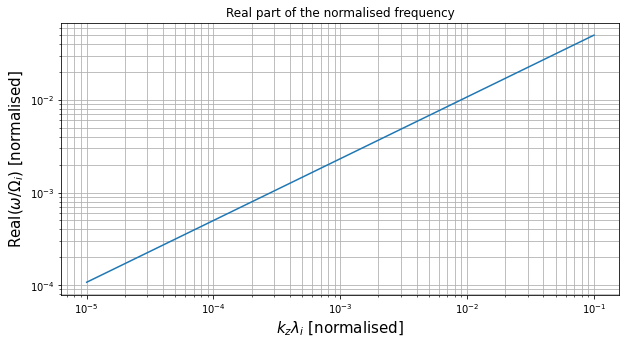

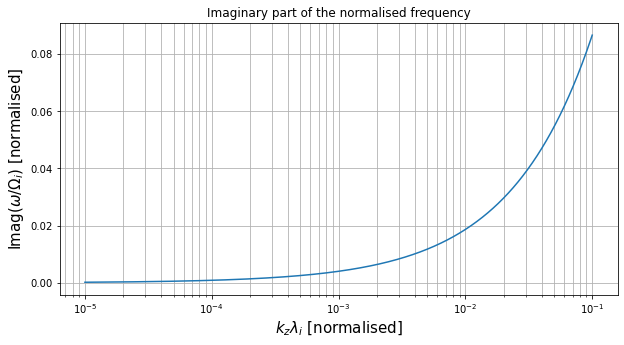

In [2]:
# plot analytical solution
import matplotlib.pyplot as plt

# plot frequency
plt.subplots(figsize=(10,5))

# plot real part
plt.plot(k_z_lambda, omega_analytical.real)
plt.xlabel('$k_z \lambda_i$ [normalised]', fontsize=15.0)
plt.title('Real part of the normalised frequency')
plt.ylabel('Real($\omega / \Omega_i$) [normalised]', fontsize=15.0)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="-")
plt.show()

# plot imaginary part
plt.subplots(figsize=(10,5))
plt.plot(k_z_lambda, omega_analytical.imag)
plt.xlabel('$k_z \lambda_i$ [normalised]', fontsize=15.0)
plt.title('Imaginary part of the normalised frequency')
plt.ylabel('Imag($\omega / \Omega_i$) [normalised]', fontsize=15.0)
plt.xscale('log')
plt.grid(True, which="both", ls="-")
plt.show()

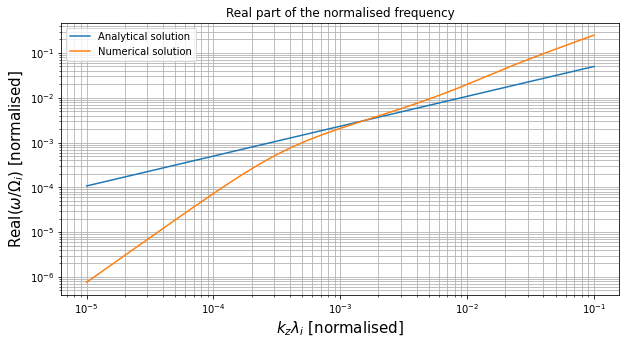

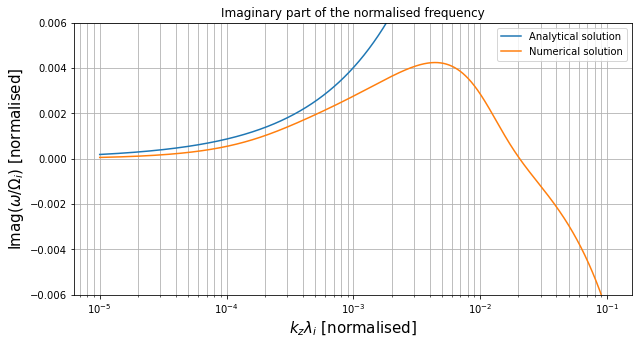

In [17]:

# plot frequency
plt.subplots(figsize=(10,5))

# plot real part of analytical solution
plt.plot(k_z_lambda, omega_analytical.real, label='Analytical solution')
# plot real part of numerical solution
plt.plot(k_z_lambda, full_omega_numerical.real, label='Numerical solution')
plt.xlabel('$k_z \lambda_i$ [normalised]', fontsize=15.0)
plt.title('Real part of the normalised frequency')
plt.ylabel('Real($\omega / \Omega_i$) [normalised]', fontsize=15.0)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()

# plot imaginary part
plt.subplots(figsize=(10,5))

# plot real part of analytical solution
plt.plot(k_z_lambda, omega_analytical.imag, label='Analytical solution')
# plot real part of numerical solution
plt.plot(k_z_lambda_list, full_omega_numerical.imag, label='Numerical solution')
plt.xlabel('$k_z \lambda_i$ [normalised]', fontsize=15.0)
plt.title('Imaginary part of the normalised frequency')
plt.ylabel('Imag($\omega / \Omega_i$) [normalised]', fontsize=15.0)
plt.xscale('log')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.ylim(-0.006, 0.006)
plt.show()

## 6. Plot everything together

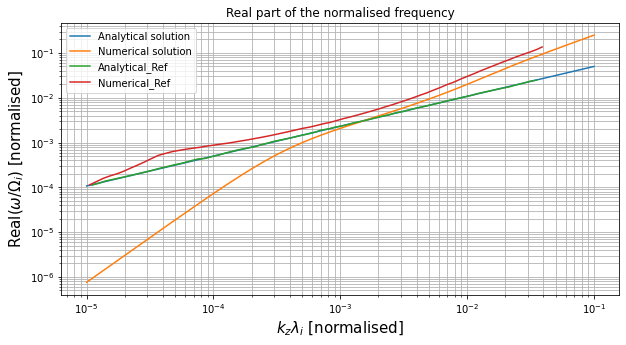

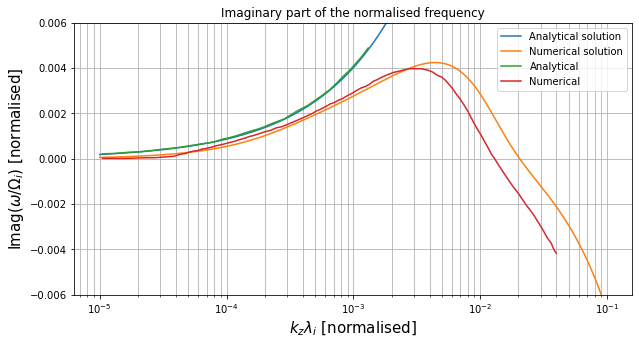

In [16]:
# plot frequency
plt.subplots(figsize=(10,5))

# plot real part of analytical solution
plt.plot(k_z_lambda, omega_analytical.real, label='Analytical solution')
# plot real part of numerical solution
plt.plot(k_z_lambda, full_omega_numerical.real, label='Numerical solution')
# reference analytical solution
plt.plot(k_z_lambda_analytical_real, frequency_analytical_real, label='Analytical_Ref')
# reference numerical solution
plt.plot(k_z_lambda_numerical_real, frequency_numerical_real, label='Numerical_Ref')

plt.xlabel('$k_z \lambda_i$ [normalised]', fontsize=15.0)
plt.title('Real part of the normalised frequency')
plt.ylabel('Real($\omega / \Omega_i$) [normalised]', fontsize=15.0)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()

# plot imaginary part
plt.subplots(figsize=(10,5))

# plot growth rate of analytical solution
plt.plot(k_z_lambda, omega_analytical.imag, label='Analytical solution')
# plot growth rate of numerical solution
plt.plot(k_z_lambda_list, full_omega_numerical.imag, label='Numerical solution')
# reference growth rate analytical
plt.plot(k_z_lambda_analytical_imaginary, growth_rate_analytical, label='Analytical')
# reference growth rate numerical
plt.plot(k_z_lambda_numerical_imaginary, growth_rate_numerical, label='Numerical')

plt.xlabel('$k_z \lambda_i$ [normalised]', fontsize=15.0)
plt.title('Imaginary part of the normalised frequency')
plt.ylabel('Imag($\omega / \Omega_i$) [normalised]', fontsize=15.0)
plt.xscale('log')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.ylim(-0.006, 0.006)
plt.show()